In [1]:
%matplotlib inline
import pandas
import os
import collections
import numpy

from train_test import find_files, parse_dates, load_series, load_data, separate_output

path = "../data/v2/train_set/"
power_data = load_series(find_files(path, "power"), resample_interval="1H")

Using Theano backend.


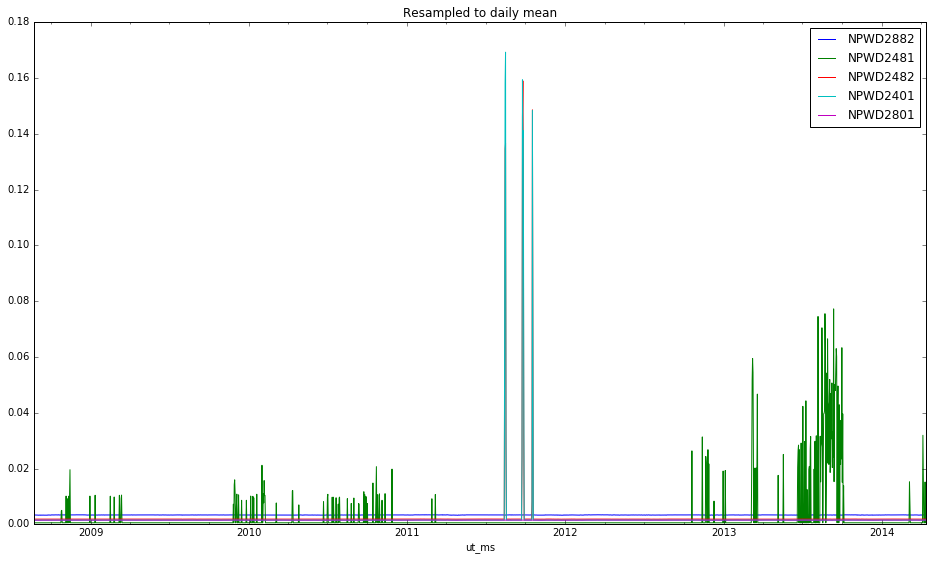

In [38]:
col_weights = power_data.mean(axis=0) #+ power_data.std(axis=0)
col_weights.sort_values(ascending=False)

ax = power_data[col_weights.sort_values(ascending=False)[20:25].index].resample("1D").mean().plot(figsize=(16, 9))
ax.set_title("Resampled to daily mean")
ax.legend(loc="upper right")
ax

/Users/keith/code/mars-express3/venv2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


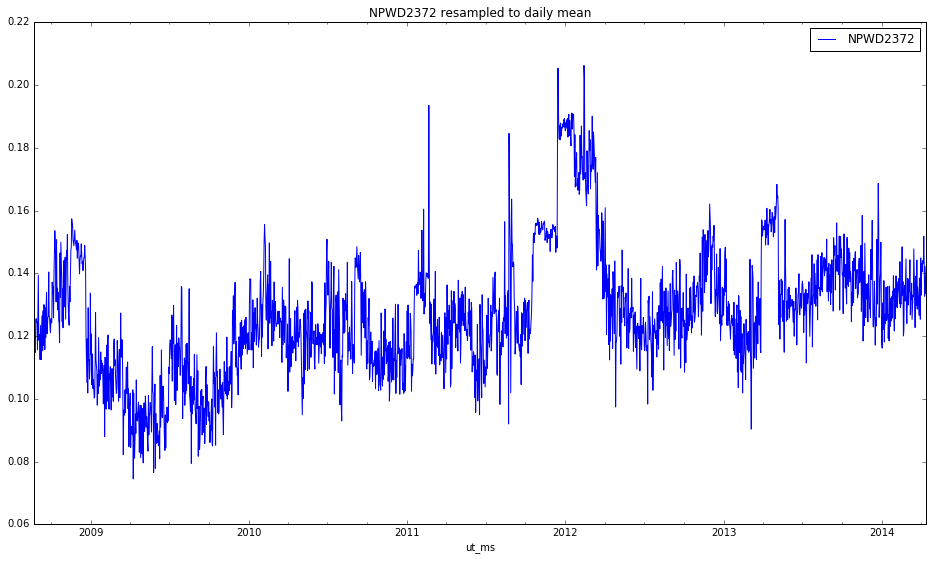

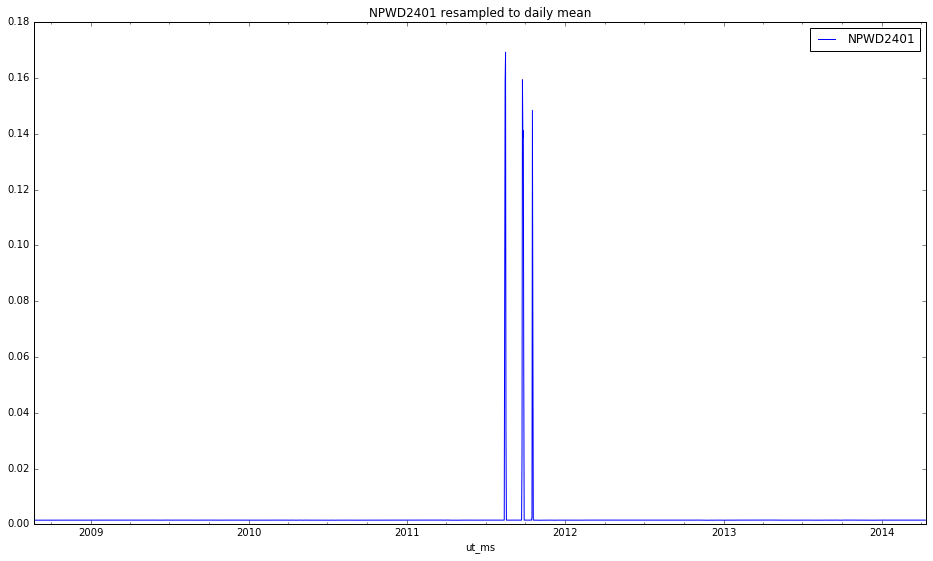

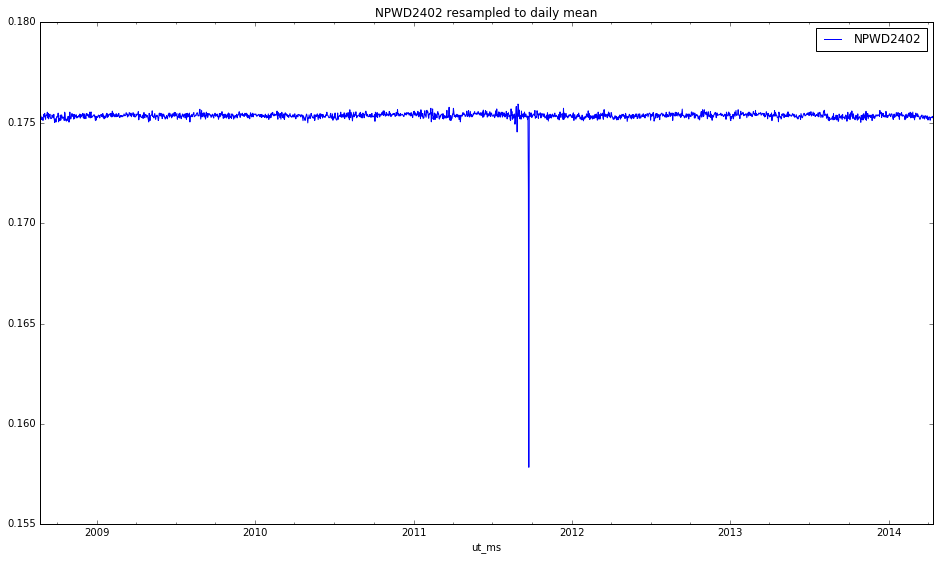

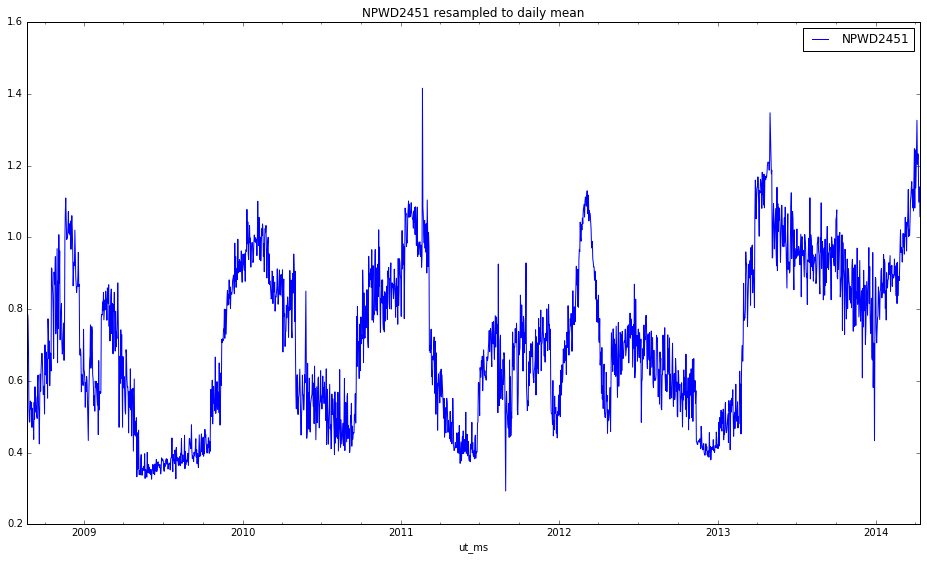

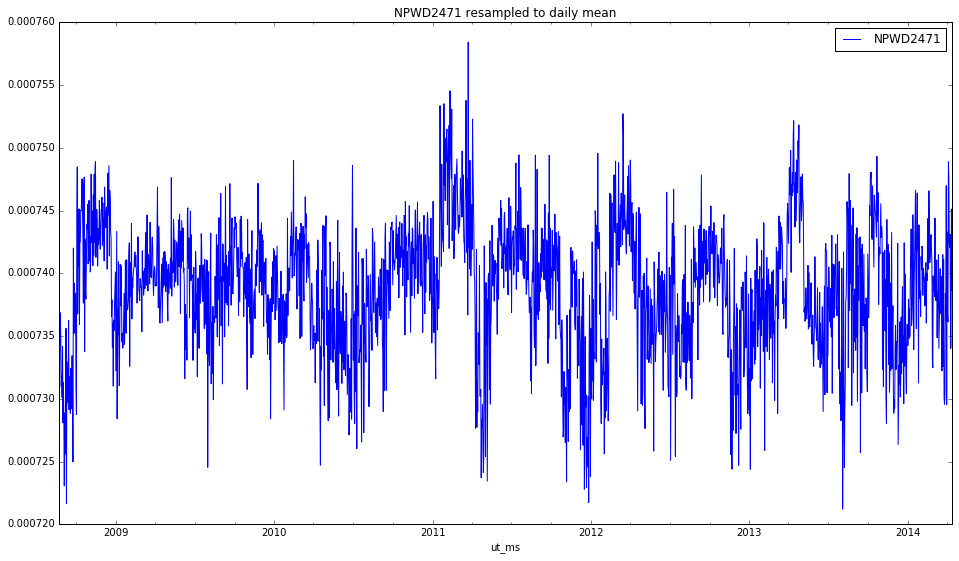

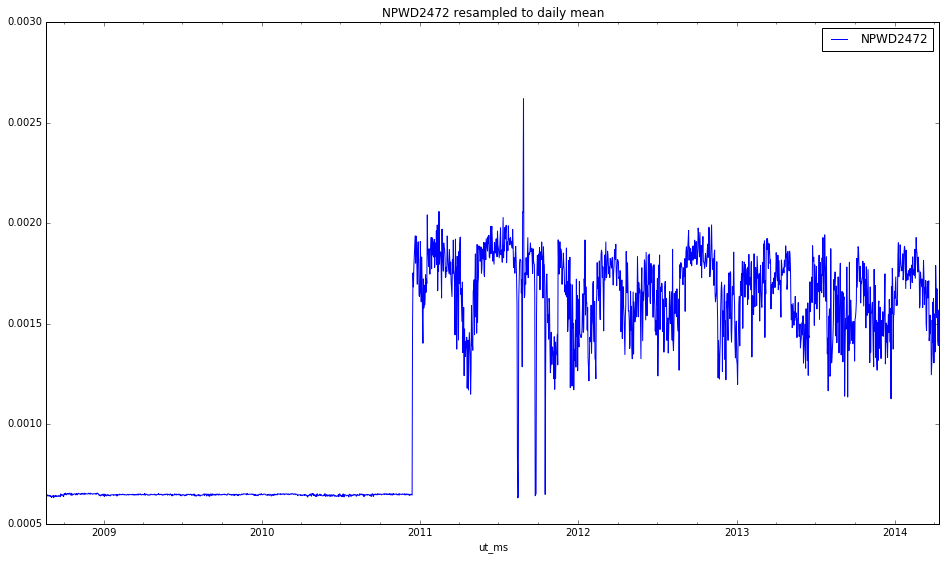

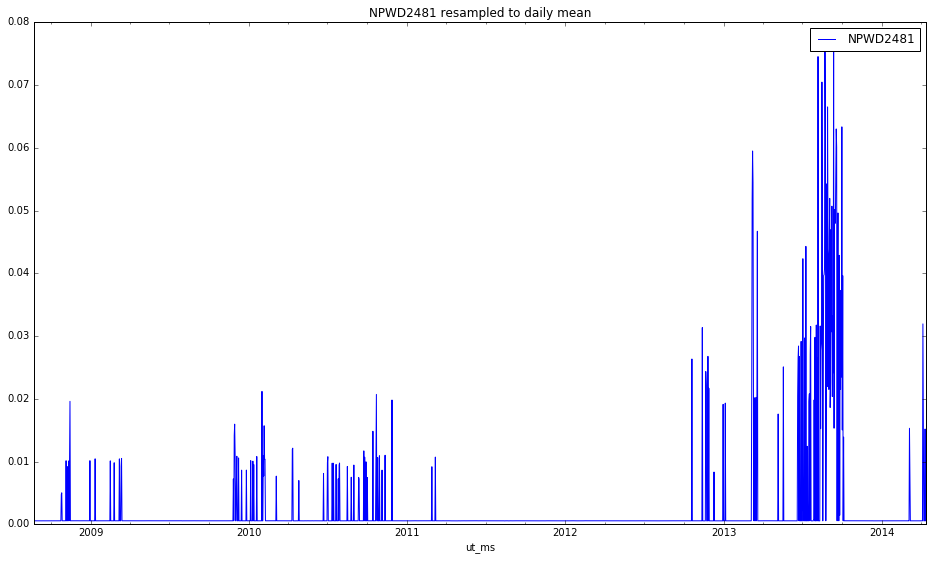

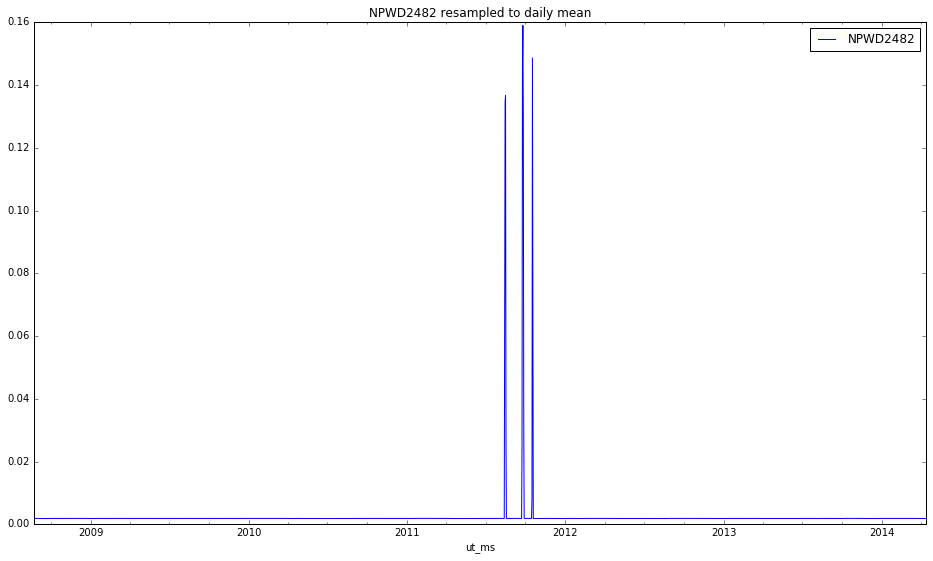

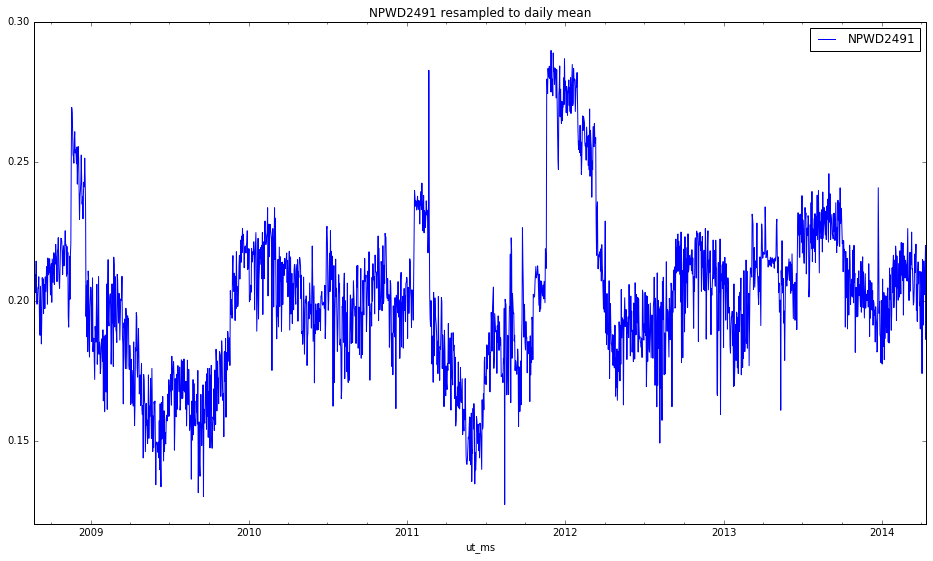

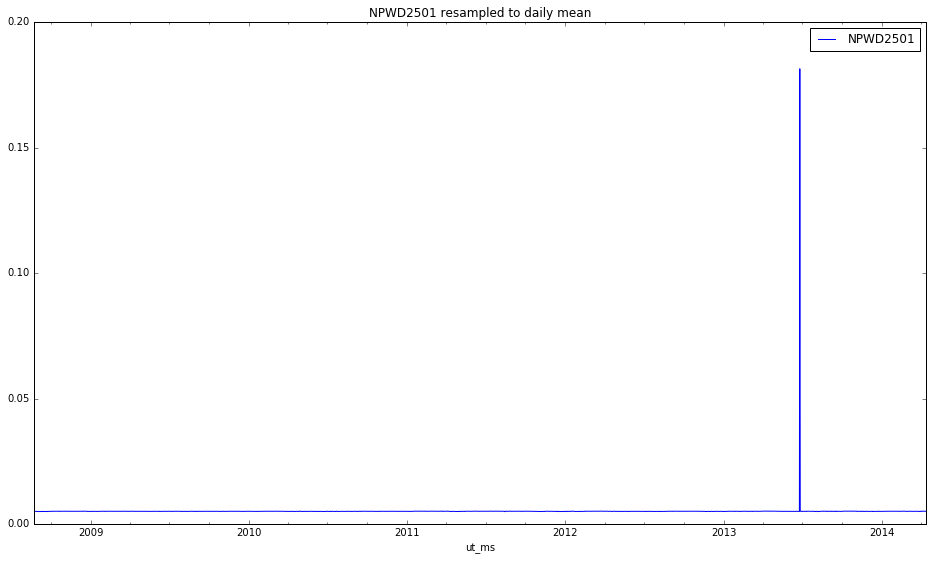

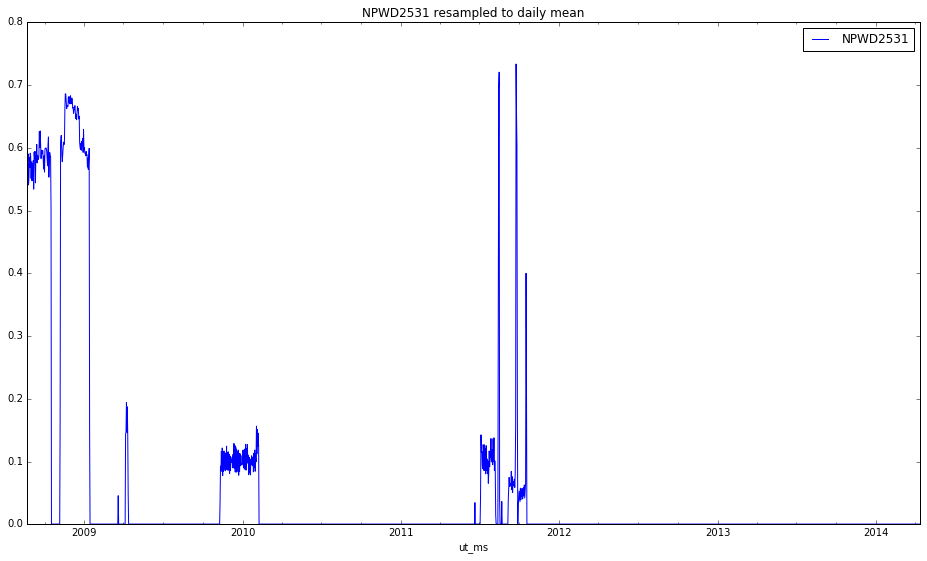

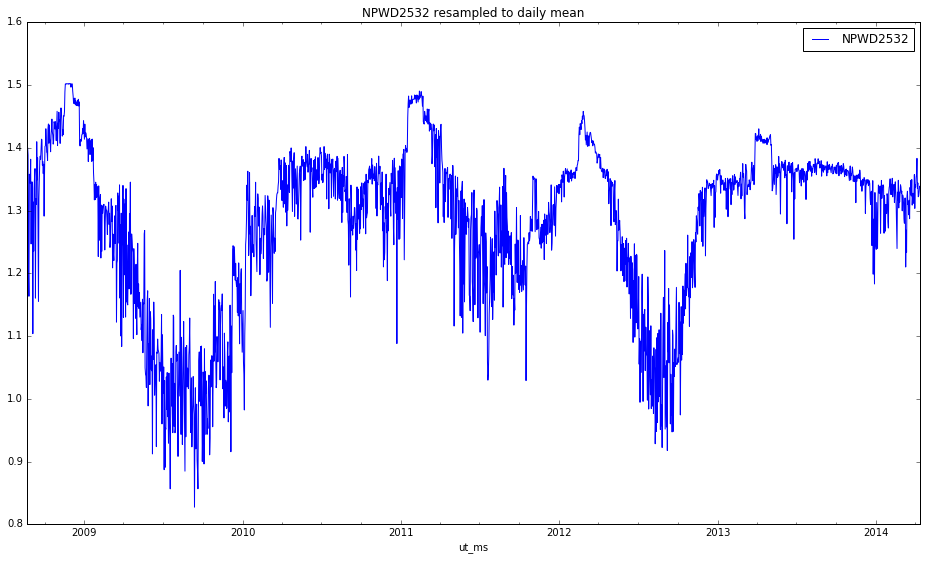

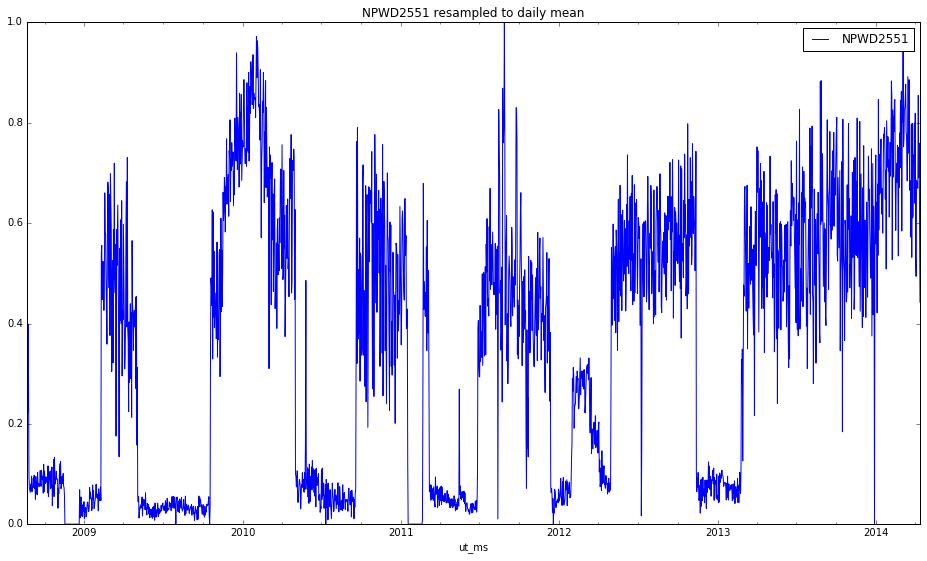

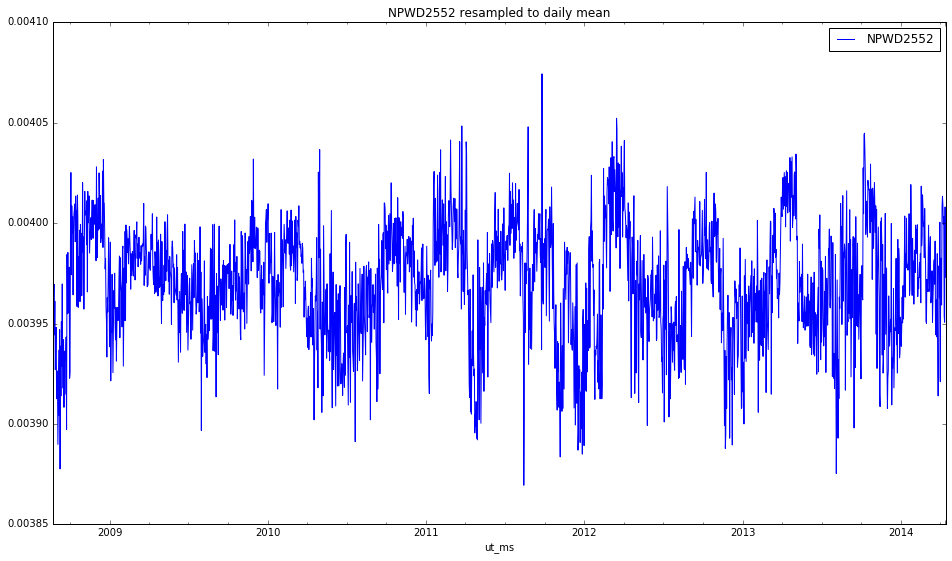

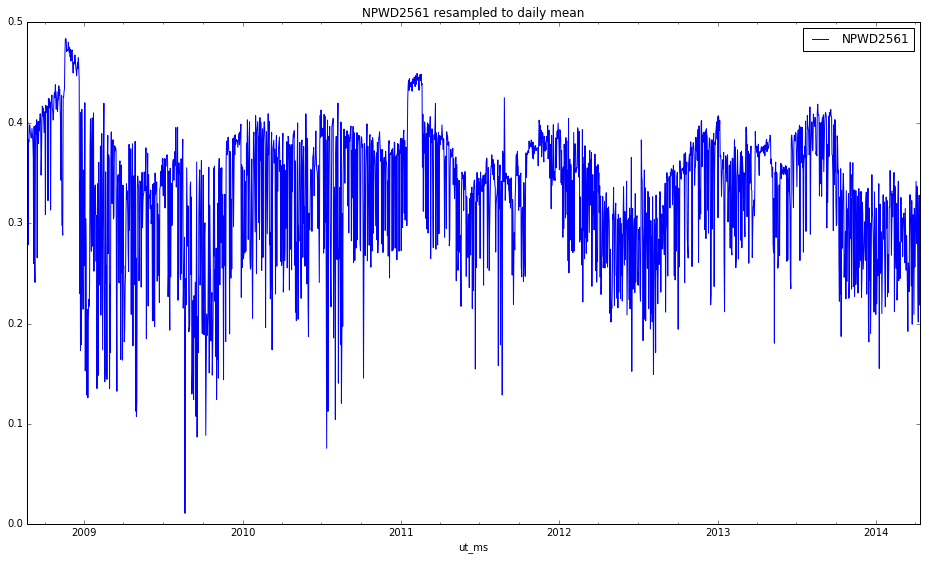

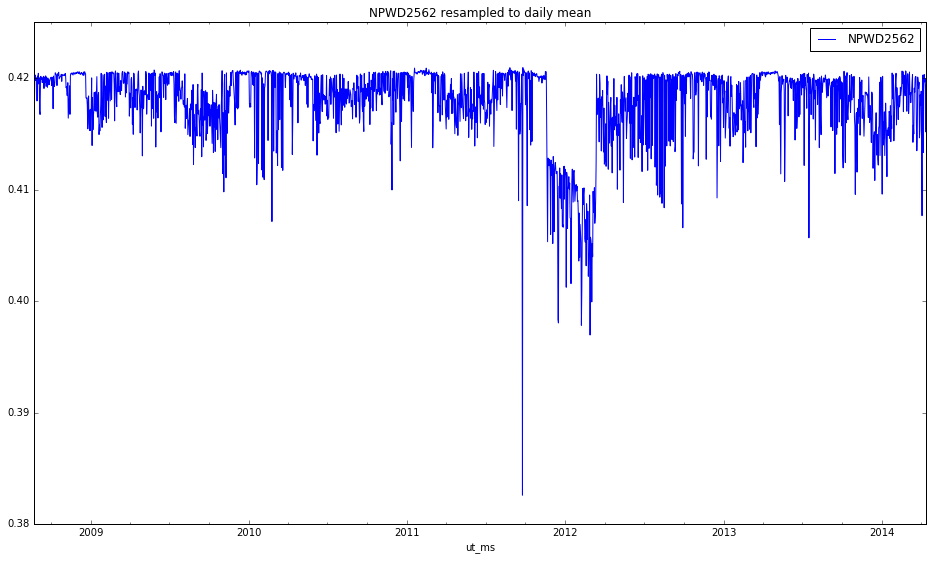

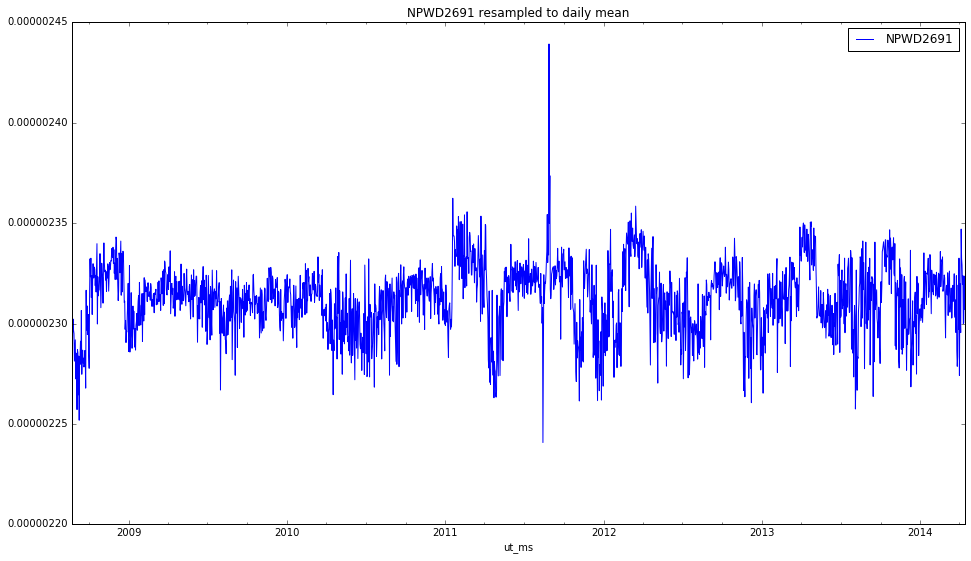

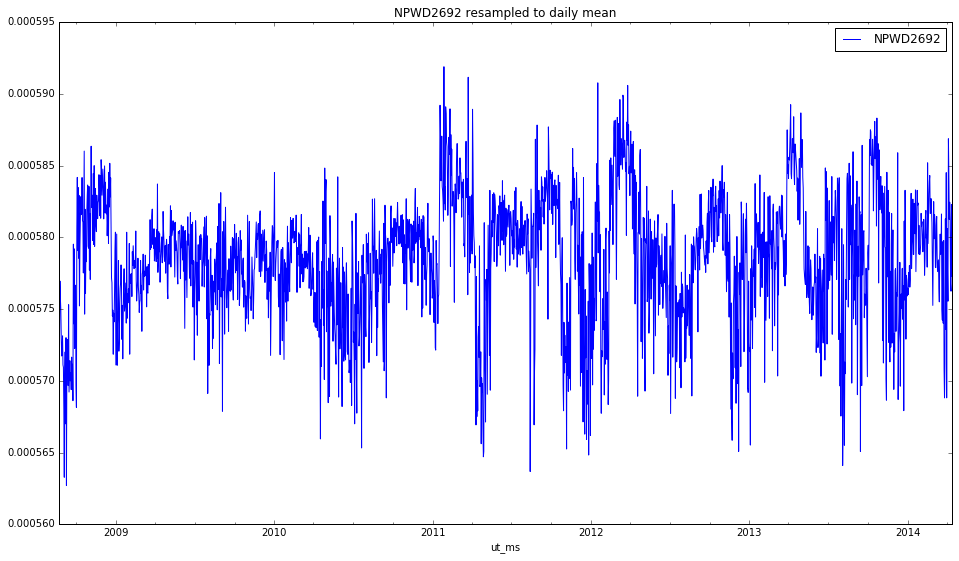

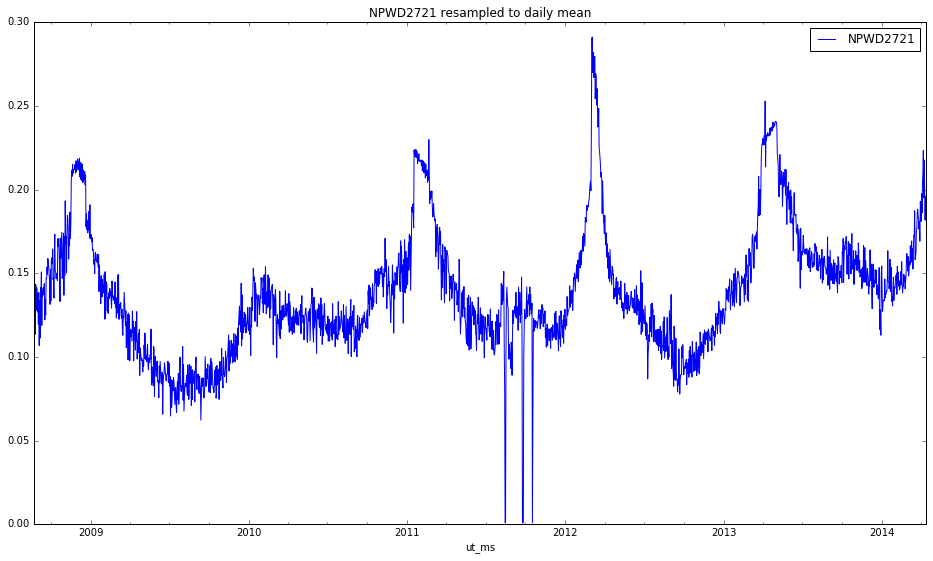

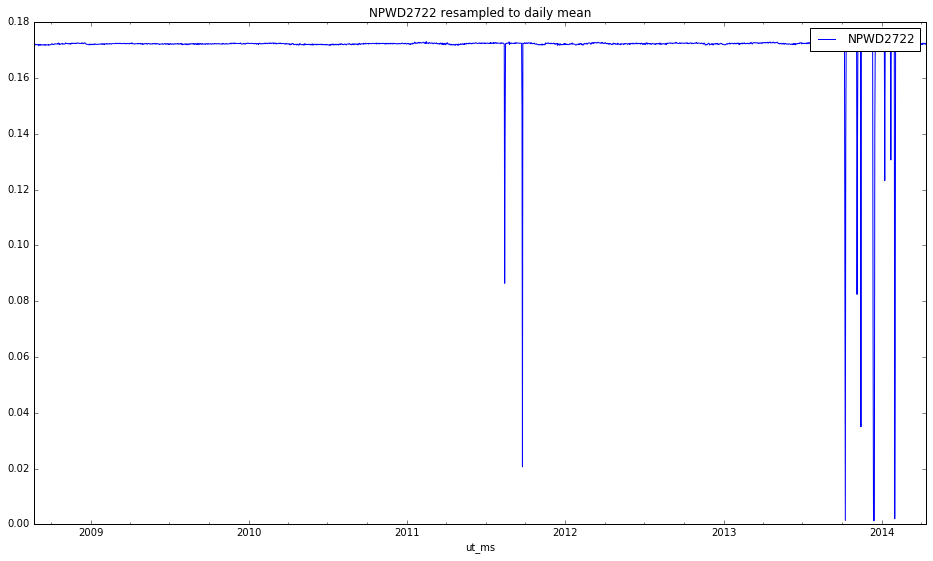

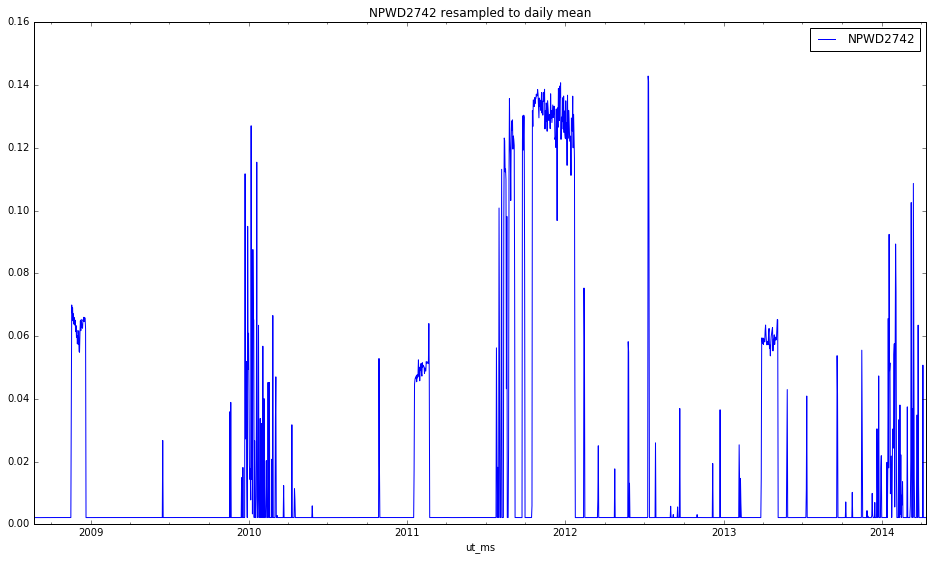

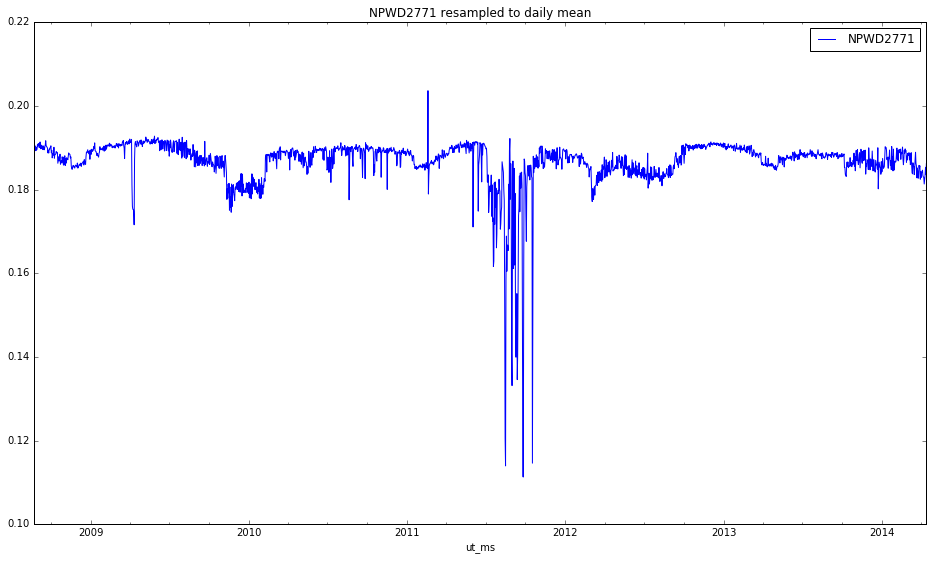

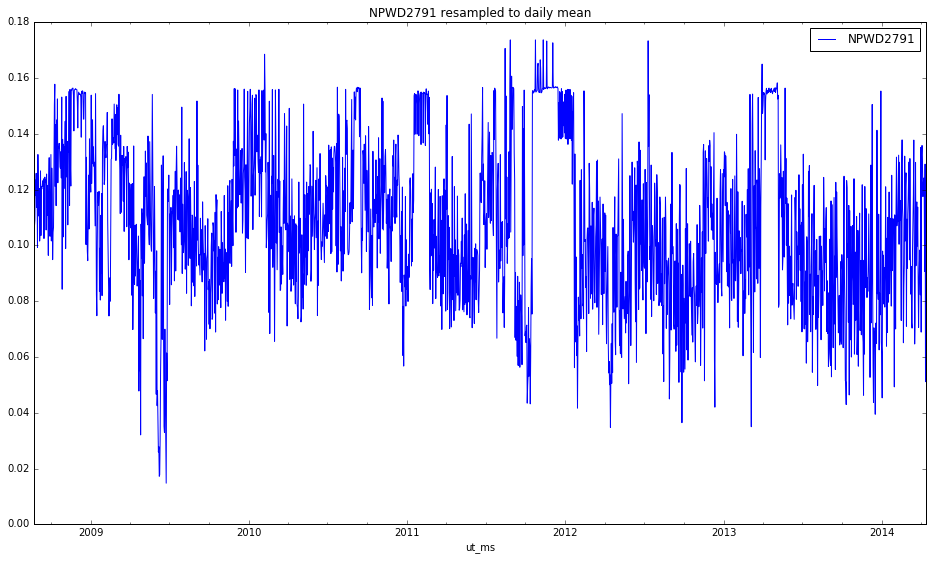

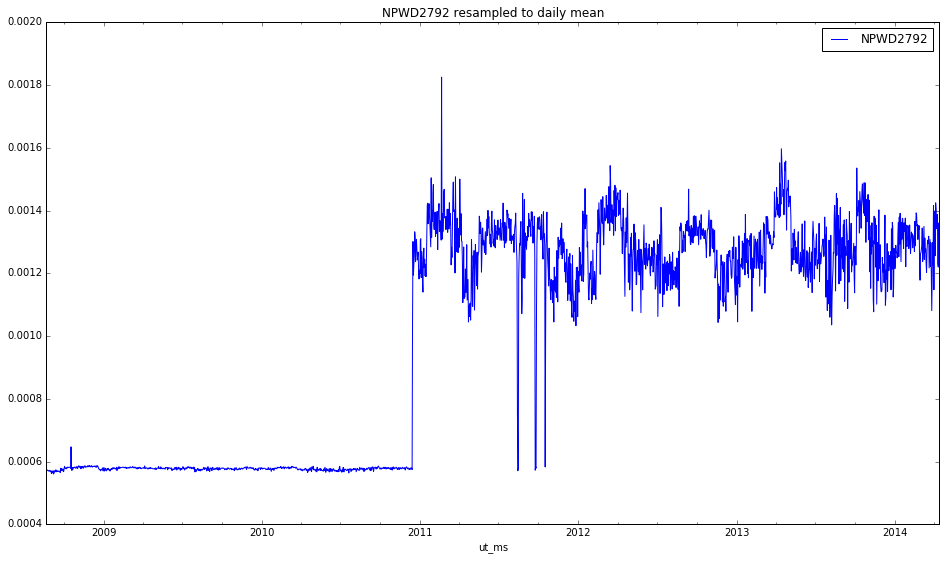

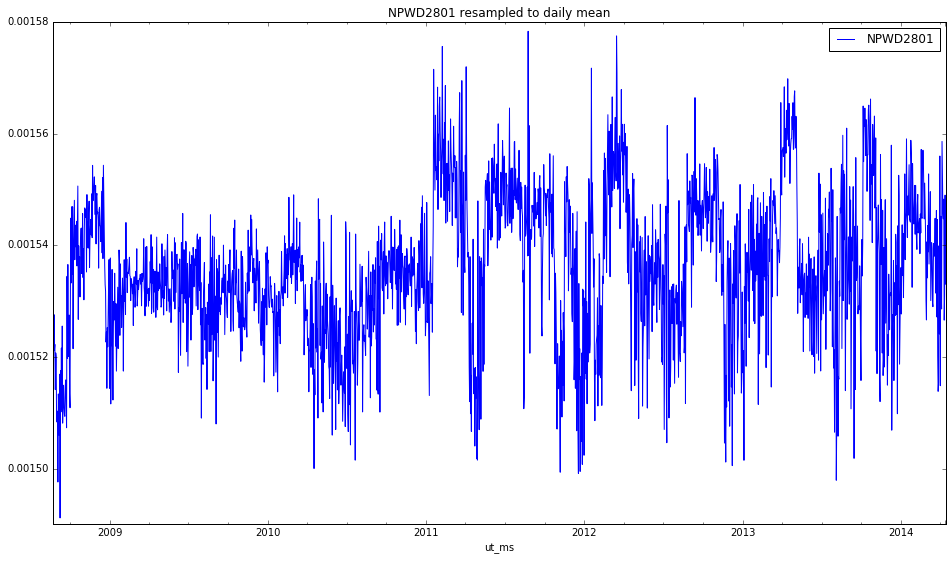

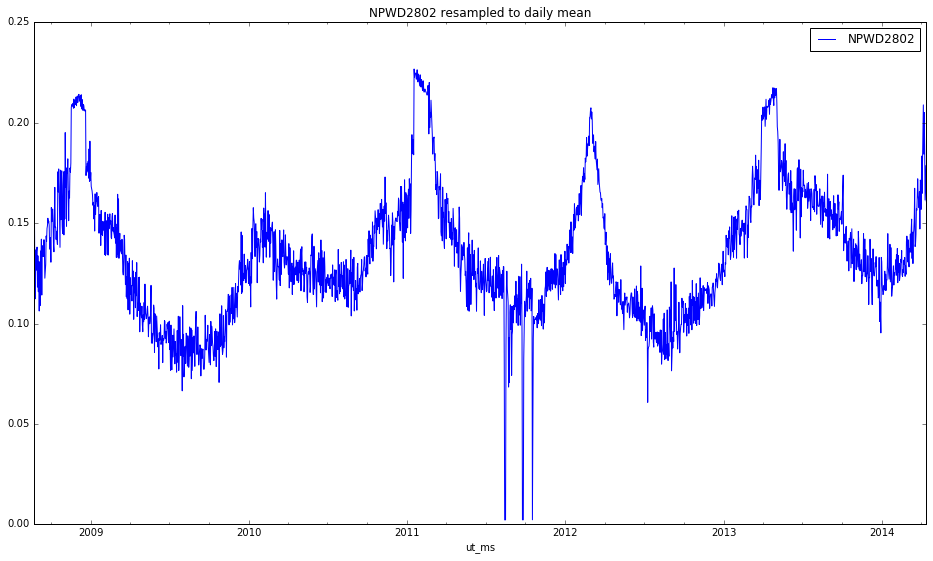

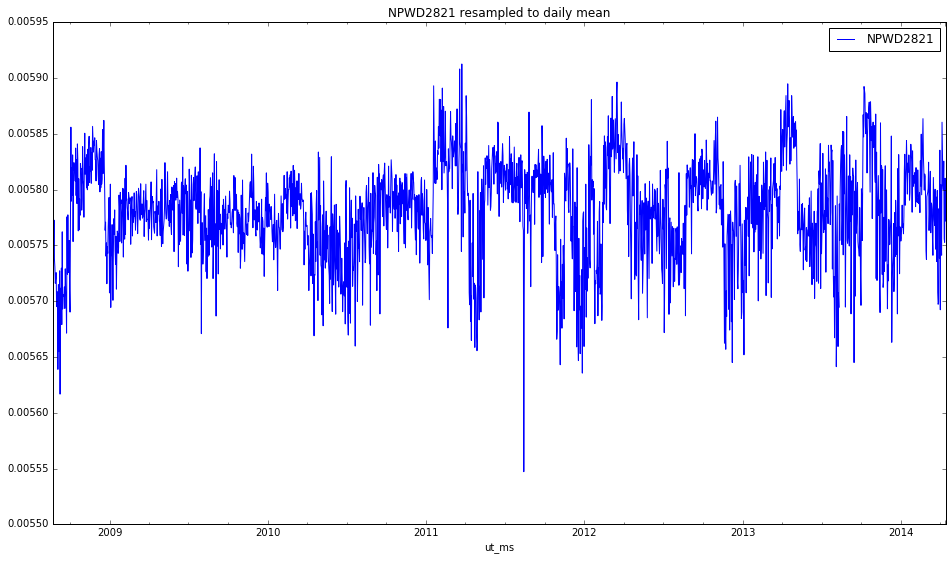

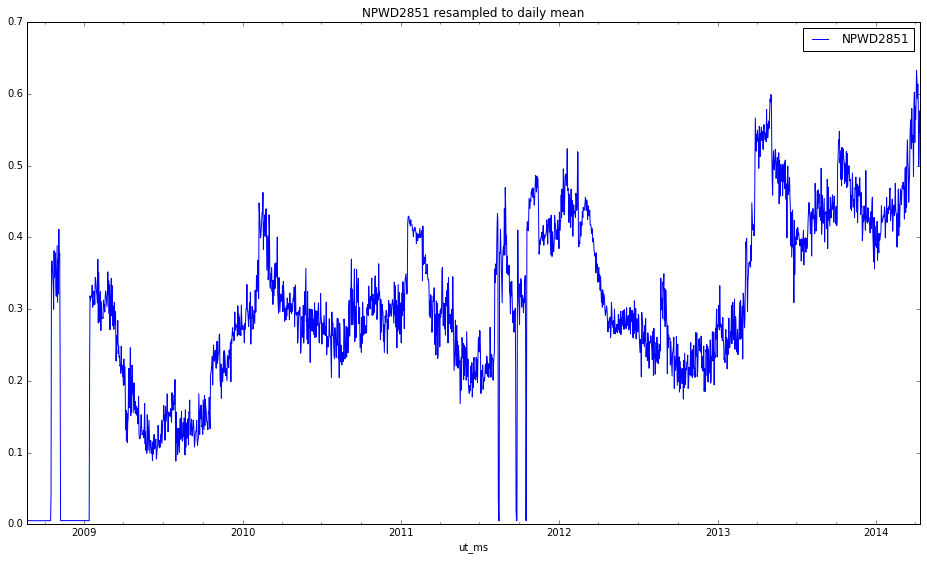

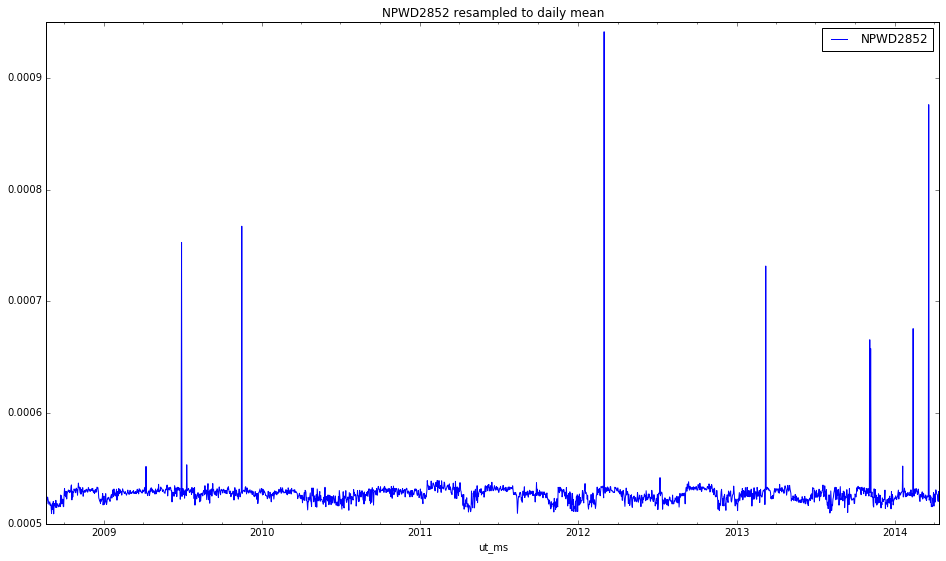

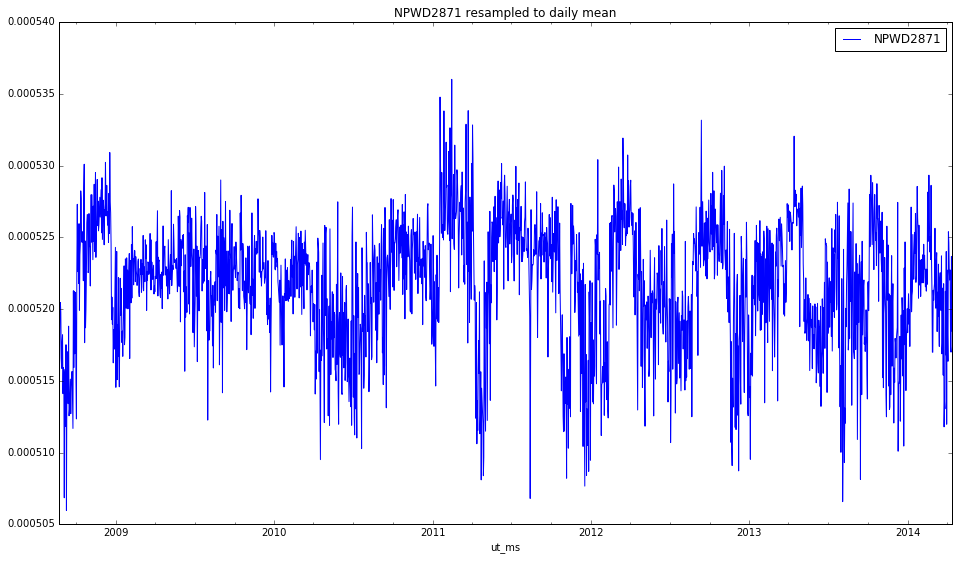

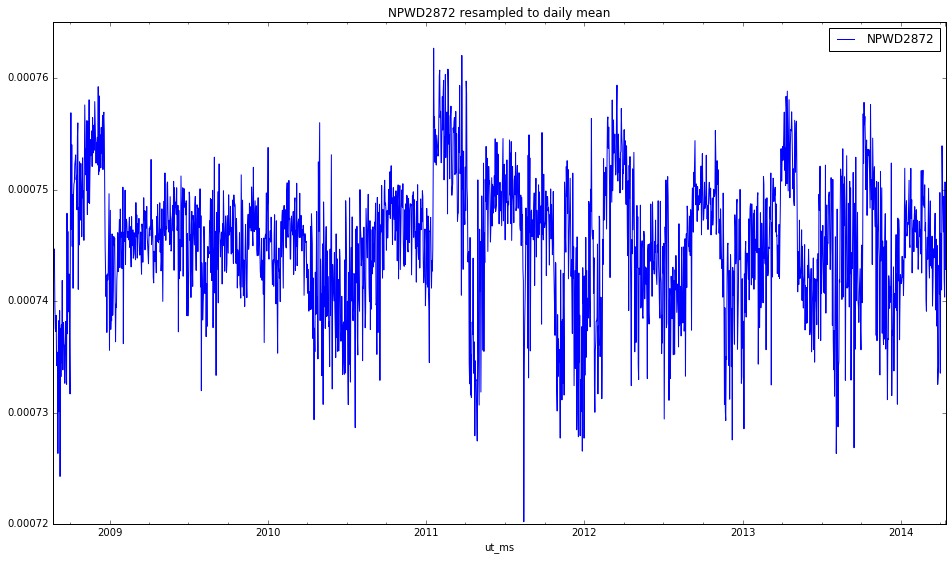

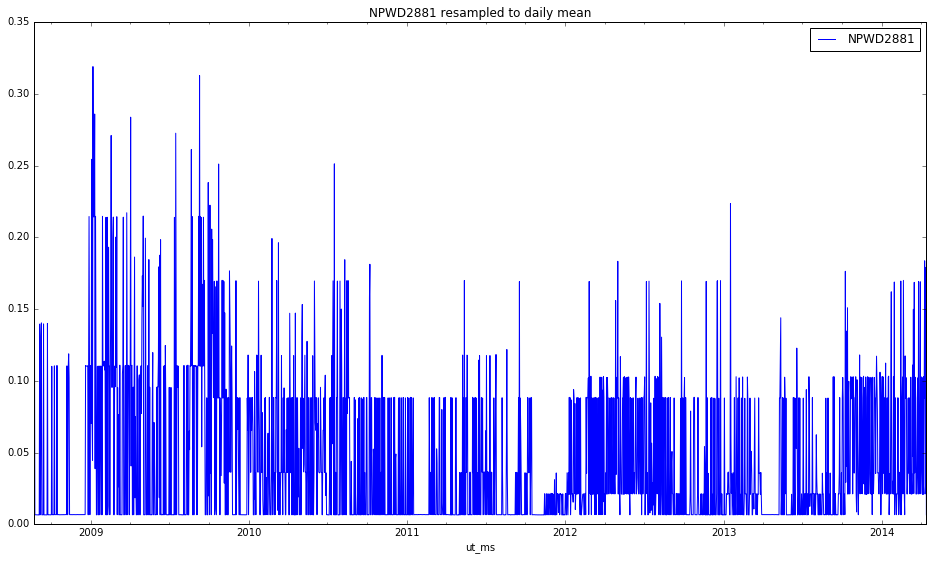

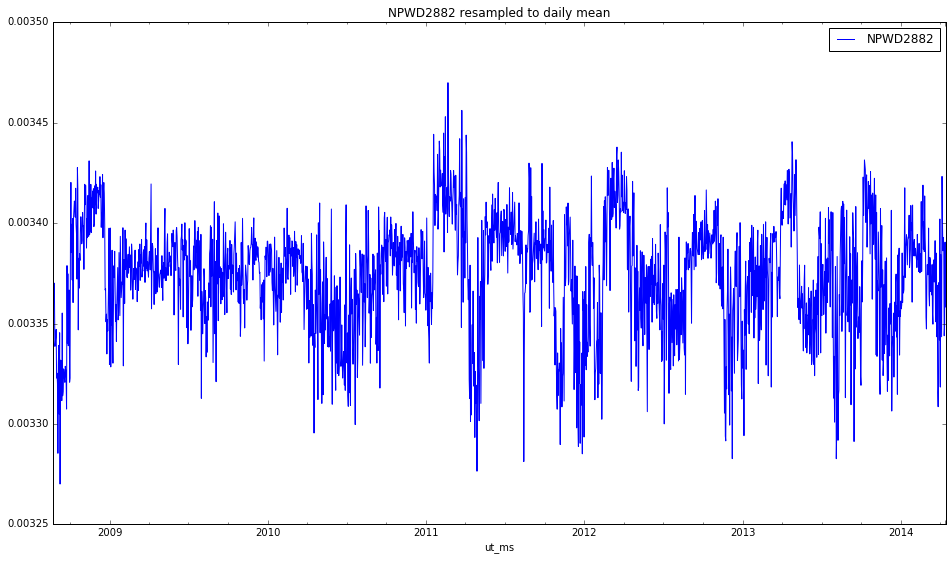

In [40]:
for col in power_data.columns:
    ax = power_data[[col]].resample("1D").mean().plot(figsize=(16, 9))
    ax.set_title(col + " resampled to daily mean")
    ax.legend(loc="upper right")
    ax.get_figure().savefig("../analysis/outputs/" + col + ".png", dpi=300)

In [2]:
pandas.set_option("display.max_rows", 500)
saaf_data = load_series(find_files(path, "saaf"))
evtf_data = load_series(find_files(path, "evtf"))
dmop_data = load_series(find_files(path, "dmop"))
ftl_data = load_series(find_files(path, "ftl"))

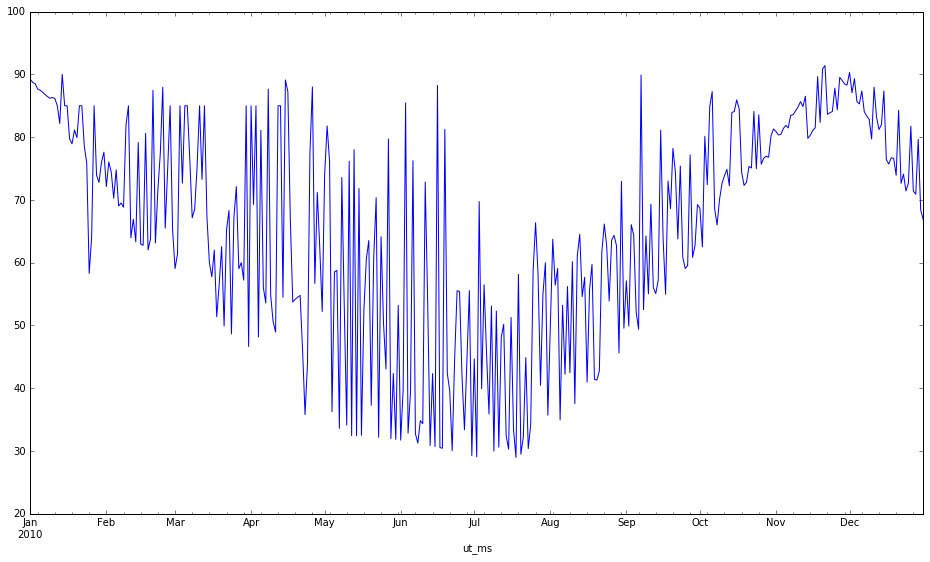

In [31]:
saaf_data.sx["2010"].resample("1D").max().plot(figsize=(16,9))

In [12]:
from train_test import get_dmop_subsystem

vc = get_dmop_subsystem(dmop_data).value_counts()

list(vc[vc > 1000].index)

['AAAF56A1',
 'ACFE91A',
 'PSF28A1',
 'ACFE03A',
 'PSF38A1',
 'AAAF20E1',
 'VVV02A0',
 'VVV03B0',
 'AAAF20C1',
 'MMMF10A0',
 'MAPO',
 'ACFE05A',
 'MPER',
 'AAAF23G1',
 'AAAF57A1',
 'AAAF60A1',
 'MMMF18A0',
 'MMMF19A0',
 'PSF32A1',
 'PSF50A2',
 'ACFM07A',
 'MOCE',
 'ACFM06A',
 'MOCS',
 'AAAF93A1',
 'AAAF59A1',
 'PENS',
 'PENE',
 'PSF12H1',
 'SSSF06A0',
 'SSSF01A0',
 'MMMF23A0',
 'MMMF24A0',
 'ACFM01A',
 'ACFM02A',
 'TTTF030A',
 'TTTF030B',
 'TTTF310B',
 'TTTF310A',
 'MMMF05A0',
 'MMMF01A0',
 'MMMF06A0',
 'AAAF84A1',
 'AAAF85A1',
 'MMMF04A0',
 'MMMF12A0',
 'MMMF11A0',
 'MMMF40C0',
 'MMMF20A0',
 'PSF60A0',
 'PSF60B0',
 'AAAF40B0',
 'AAAF40C0',
 'PSF30C2',
 'SSSF53A0',
 'PSF30A1',
 'PSF03A3',
 'PSF33A1',
 'PSF13A3',
 'PSF82A1',
 'PSF30B2',
 'PSF89A1',
 'PSF31A1',
 'TTTF301F',
 'PSF14A2',
 'PSF02A1',
 'PSF40A1',
 'PSF31B1',
 'AAAF20D1',
 'PSF37A1',
 'AAAF18D1',
 'AAAF19D1',
 'MMMF40A0',
 'PSF23B1',
 'PSF01A2',
 'SSSF01P0',
 'SSSF06P0',
 'AAAF23I1',
 'TTTF301E',
 'SEQ4200',
 'PSF06A2',
 'HHH